# Telco Customer Churn – EDA & Modeling

End-to-end exploration and churn prediction on the Telco Customer Churn dataset. Includes data quality checks, preprocessing, baseline and boosted models, and evaluation plots.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

DATA_PATH = os.path.join("..", "WA_Fn-UseC_-Telco-Customer-Churn.csv")
DATA_PATH_LOCAL = os.path.join("..", "data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Prefer the copy under data/, fallback to repo root
if os.path.exists(DATA_PATH_LOCAL):
    DATA_PATH = DATA_PATH_LOCAL

DATA_PATH

'../data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [2]:
# Load data
raw_df = pd.read_csv(DATA_PATH)
raw_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Basic dataset overview
print(f"Rows, columns: {raw_df.shape}")
print("Columns:\n", raw_df.columns.tolist())
print("\nChurn distribution:\n", raw_df["Churn"].value_counts(normalize=True).rename("share"))

# Identify blank strings in numeric-looking TotalCharges
blank_total = (raw_df["TotalCharges"].astype(str).str.strip() == "").sum()
print(f"Blank TotalCharges entries (need cleaning): {blank_total}")

raw_df.describe(include="all").transpose().head()

Rows, columns: (7043, 21)
Columns:
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Churn distribution:
 Churn
No     0.73463
Yes    0.26537
Name: share, dtype: float64
Blank TotalCharges entries (need cleaning): 11


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Clean TotalCharges and make a working copy

df = raw_df.copy()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].astype(str).str.strip(), errors="coerce")

# Report missing after coercion
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

TotalCharges    11
dtype: int64

In [5]:
# Impute the small number of missing TotalCharges with median
median_total = df["TotalCharges"].median()
df["TotalCharges"] = df["TotalCharges"].fillna(median_total)

df.isna().sum().any()

np.False_

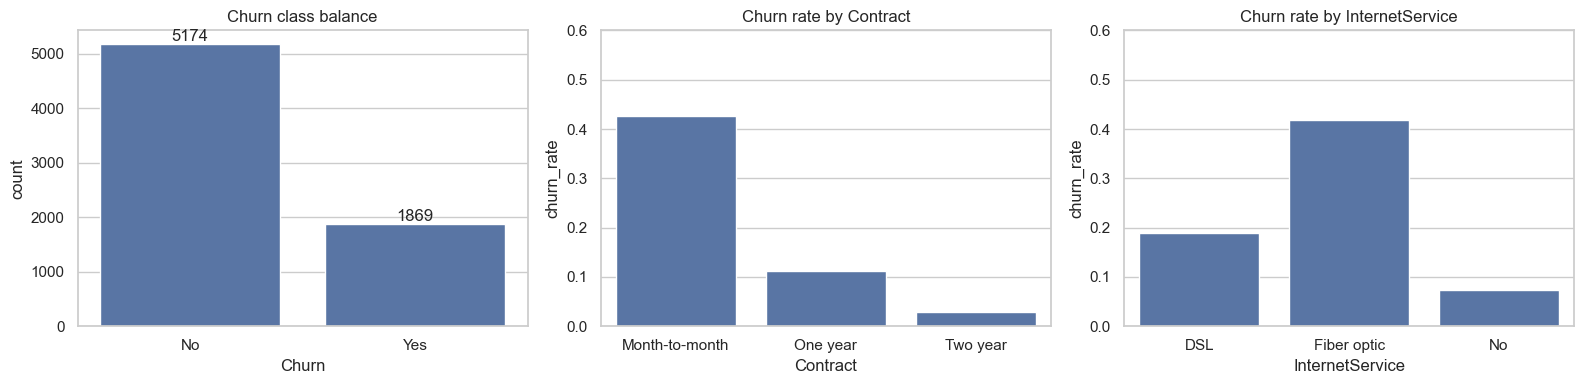

In [6]:
# Churn balance and key categorical relationships
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

sns.countplot(data=df, x="Churn", ax=axes[0])
axes[0].set_title("Churn class balance")
axes[0].bar_label(axes[0].containers[0])

sns.barplot(
    data=df.groupby("Contract")["Churn"].apply(lambda x: (x == "Yes").mean()).reset_index(name="churn_rate"),
    x="Contract",
    y="churn_rate",
    ax=axes[1],
)
axes[1].set_title("Churn rate by Contract")
axes[1].set_ylim(0, 0.6)

sns.barplot(
    data=df.groupby("InternetService")["Churn"].apply(lambda x: (x == "Yes").mean()).reset_index(name="churn_rate"),
    x="InternetService",
    y="churn_rate",
    ax=axes[2],
)
axes[2].set_title("Churn rate by InternetService")
axes[2].set_ylim(0, 0.6)

plt.tight_layout()
plt.show()

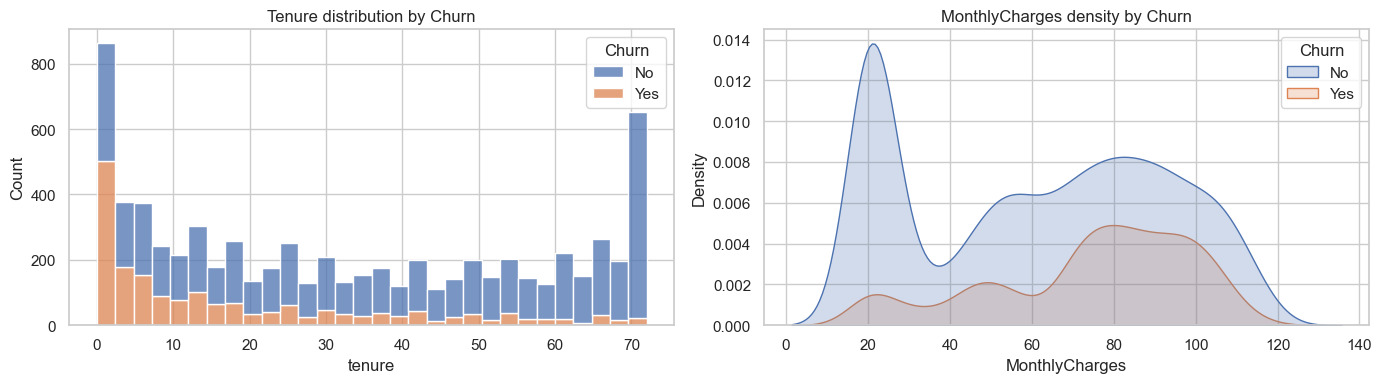

In [7]:
# Numeric distributions by churn
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.histplot(data=df, x="tenure", hue="Churn", multiple="stack", bins=30, ax=axes[0])
axes[0].set_title("Tenure distribution by Churn")

sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True, ax=axes[1])
axes[1].set_title("MonthlyCharges density by Churn")

plt.tight_layout()
plt.show()

In [8]:
# Train/validation split and preprocessing

target = "Churn"
X = df.drop(columns=[target])
y = (df[target] == "Yes").astype(int)

categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
numeric_cols = [c for c in X.columns if X[c].dtype != "object"]

categorical_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numeric_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_processor, categorical_cols),
        ("numeric", numeric_processor, numeric_cols),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (5634, 20), Test size: (1409, 20)


In [9]:
# Feature engineering to capture service patterns and price sensitivity

def add_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df2 = df_in.copy()
    # Buckets for tenure
    df2["tenure_bucket"] = pd.cut(df2["tenure"], bins=[-1, 6, 12, 24, 48, 72, 100], labels=["0-6", "7-12", "13-24", "25-48", "49-72", "72+"]).astype(str)
    # Service counts
    service_cols = [
        "PhoneService",
        "MultipleLines",
        "OnlineSecurity",
        "OnlineBackup",
        "DeviceProtection",
        "TechSupport",
        "StreamingTV",
        "StreamingMovies",
    ]
    df2["services_count"] = df2[service_cols].applymap(lambda x: 1 if x == "Yes" else 0).sum(axis=1)
    df2["streaming_count"] = df2[["StreamingTV", "StreamingMovies"]].applymap(lambda x: 1 if x == "Yes" else 0).sum(axis=1)
    # Contract numeric and autopay flag
    contract_months_map = {"Month-to-month": 1, "One year": 12, "Two year": 24}
    df2["contract_months"] = df2["Contract"].map(contract_months_map)
    df2["is_autopay"] = df2["PaymentMethod"].str.contains("automatic", case=False).astype(int)
    # Price ratios
    df2["charge_per_service"] = df2["MonthlyCharges"] / (df2["services_count"] + 1)
    df2["total_over_tenure"] = df2["TotalCharges"] / (df2["tenure"] + 1)
    # Fiber and phone+internet flags
    df2["is_fiber"] = (df2["InternetService"] == "Fiber optic").astype(int)
    df2["has_phone_and_internet"] = ((df2["PhoneService"] == "Yes") & (df2["InternetService"] != "No"))
    df2["has_phone_and_internet"] = df2["has_phone_and_internet"].astype(int)
    return df2

# Apply feature engineering
fe_df = add_features(df)
X_fe = fe_df.drop(columns=[target])
y_fe = y.copy()

# Split for feature-engineered set (CatBoost-friendly)
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=42, stratify=y_fe
)
X_train_fe_sub, X_val_fe, y_train_fe_sub, y_val_fe = train_test_split(
    X_train_fe, y_train_fe, test_size=0.2, random_state=42, stratify=y_train_fe
)

cat_features_fe = [c for c in X_fe.columns if X_fe[c].dtype == "object"]
cat_idx_fe = [X_fe.columns.get_loc(c) for c in cat_features_fe]

print("Feature-engineered columns added:", set(fe_df.columns) - set(df.columns))
print(f"FE train/test shapes: {X_train_fe.shape}, {X_test_fe.shape}")

Feature-engineered columns added: {'streaming_count', 'contract_months', 'is_fiber', 'charge_per_service', 'is_autopay', 'has_phone_and_internet', 'services_count', 'total_over_tenure', 'tenure_bucket'}
FE train/test shapes: (5634, 29), (1409, 29)


/var/folders/zk/n02p85rd0dl_bf9pbykq9j700000gn/T/ipykernel_43698/82683828.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2["services_count"] = df2[service_cols].applymap(lambda x: 1 if x == "Yes" else 0).sum(axis=1)
/var/folders/zk/n02p85rd0dl_bf9pbykq9j700000gn/T/ipykernel_43698/82683828.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2["streaming_count"] = df2[["StreamingTV", "StreamingMovies"]].applymap(lambda x: 1 if x == "Yes" else 0).sum(axis=1)


In [10]:
from typing import Tuple, Dict

def evaluate_model(model, X_test, y_test, label: str, threshold: float = 0.5) -> Dict[str, float]:
    """Evaluate a fitted model with a custom decision threshold."""
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba),
        "threshold": threshold,
    }

    print(f"\nMetrics for {label} (threshold={threshold:.2f}):")
    for k, v in metrics.items():
        if k == "threshold":
            continue
        print(f"  {k}: {v:.3f}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap="Blues")
    axes[0].set_title(f"{label} - Confusion Matrix")

    RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
    axes[1].set_title(f"{label} - ROC")

    PrecisionRecallDisplay.from_predictions(y_test, y_proba, ax=axes[2])
    axes[2].set_title(f"{label} - PR")

    plt.tight_layout()
    plt.show()

    return metrics


Metrics for Logistic Regression (threshold=0.50):
  accuracy: 0.754
  precision: 0.525
  recall: 0.757
  f1: 0.620
  roc_auc: 0.841
  pr_auc: 0.632


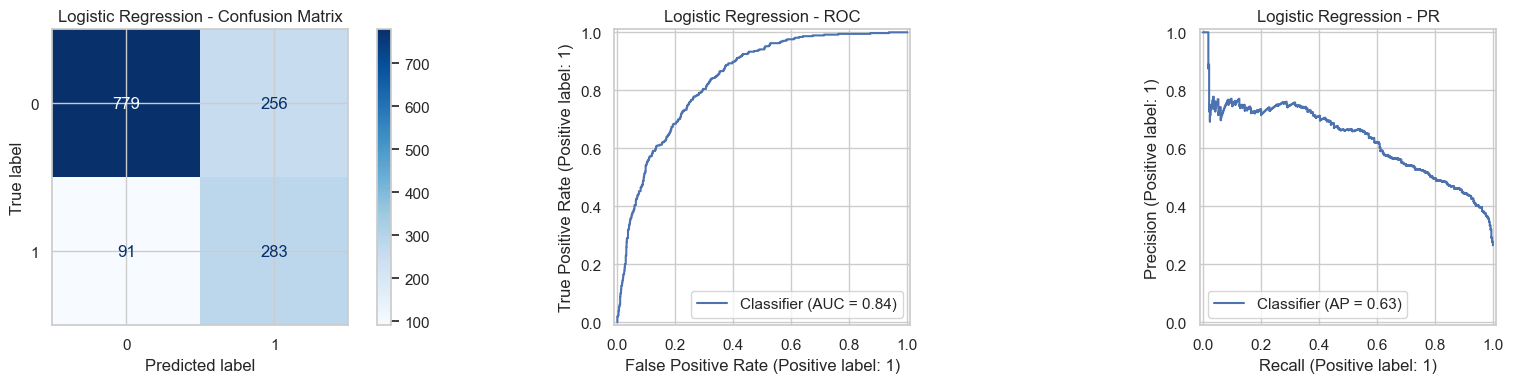

In [11]:
# Baseline: regularized logistic regression
log_reg_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            LogisticRegression(
                max_iter=500,
                class_weight="balanced",  # handle slight imbalance
                solver="liblinear",
            ),
        ),
    ]
)

log_reg_clf.fit(X_train, y_train)
log_reg_metrics = evaluate_model(log_reg_clf, X_test, y_test, label="Logistic Regression")


Metrics for Random Forest (threshold=0.50):
  accuracy: 0.703
  precision: 0.467
  recall: 0.821
  f1: 0.595
  roc_auc: 0.812
  pr_auc: 0.595


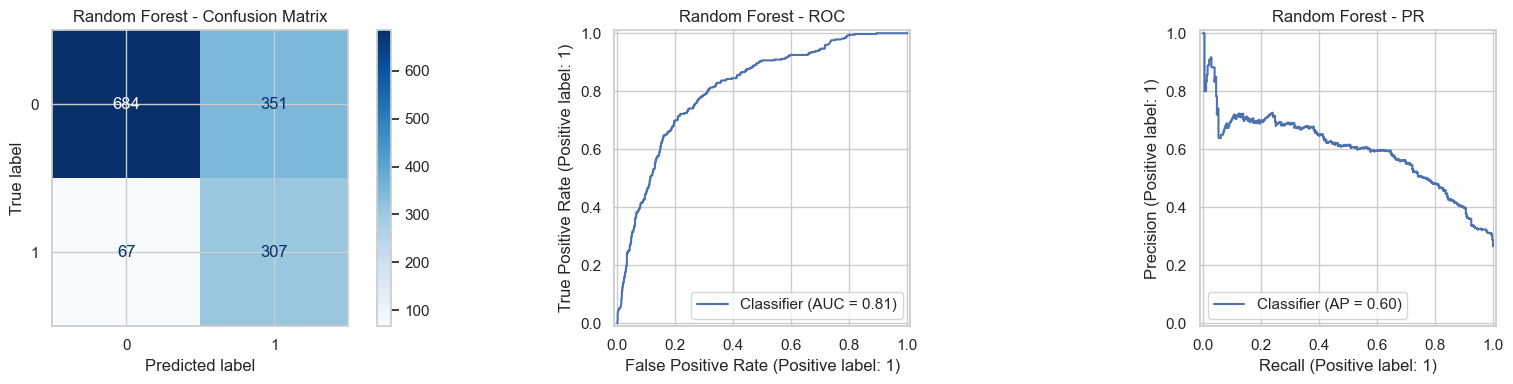

In [12]:
# Tree-based model: Random Forest (quick, handles non-linearity)
rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            RandomForestClassifier(
                n_estimators=300,
                max_depth=None,
                min_samples_leaf=2,
                class_weight="balanced",
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

rf_clf.fit(X_train, y_train)
rf_metrics = evaluate_model(rf_clf, X_test, y_test, label="Random Forest")


Metrics for HistGradientBoosting (threshold=0.50):
  accuracy: 0.786
  precision: 0.618
  recall: 0.503
  f1: 0.555
  roc_auc: 0.832
  pr_auc: 0.640


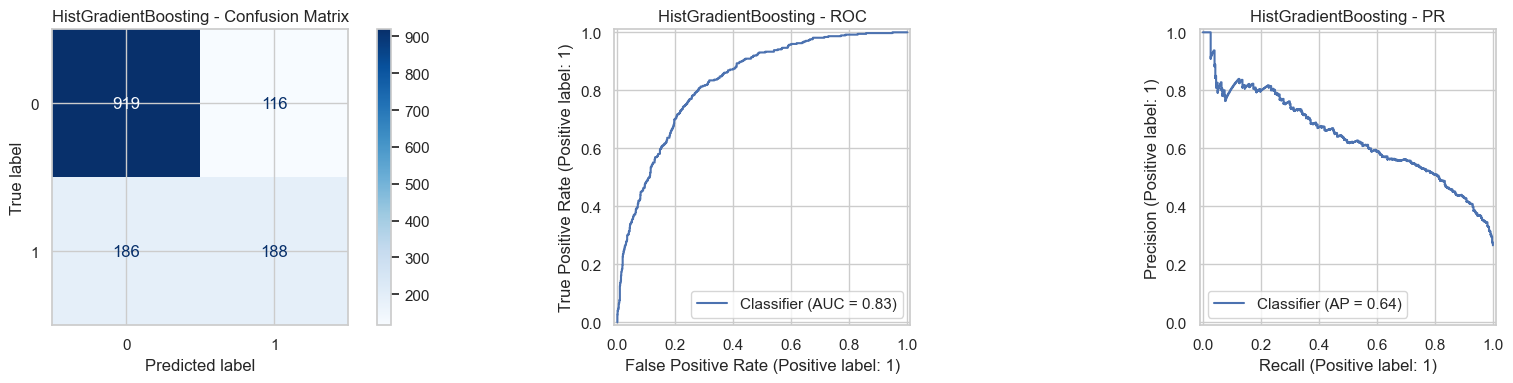

In [13]:
# Gradient boosting on dense features for potentially higher AUC

dense_categorical = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

dense_numeric = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

dense_preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", dense_categorical, categorical_cols),
        ("numeric", dense_numeric, numeric_cols),
    ],
    remainder="drop",
)

hgb_clf = Pipeline(
    steps=[
        ("preprocess", dense_preprocessor),
        (
            "model",
            HistGradientBoostingClassifier(
                learning_rate=0.05,
                max_depth=6,
                max_iter=300,
                min_samples_leaf=20,
                random_state=42,
            ),
        ),
    ]
)

hgb_clf.fit(X_train, y_train)
hgb_metrics = evaluate_model(hgb_clf, X_test, y_test, label="HistGradientBoosting")


Metrics for CatBoost_FE (threshold=0.46):
  accuracy: 0.796
  precision: 0.629
  recall: 0.567
  f1: 0.596
  roc_auc: 0.842
  pr_auc: 0.652


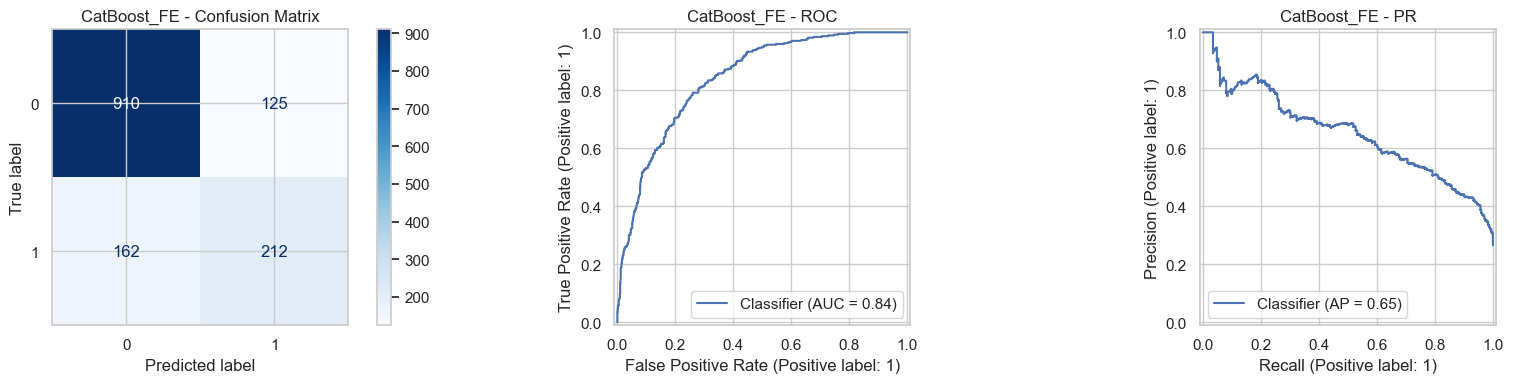

In [14]:
# CatBoost with feature-engineered inputs and tuned threshold
cat_fe_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.06,
    depth=9,
    l2_leaf_reg=3.5,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False,
)

cat_fe_model.fit(
    X_train_fe_sub,
    y_train_fe_sub,
    cat_features=cat_idx_fe,
    eval_set=(X_val_fe, y_val_fe),
    use_best_model=True,
)

val_fe_proba = cat_fe_model.predict_proba(X_val_fe)[:, 1]
thresholds_fe = np.linspace(0.3, 0.7, 41)
val_acc_fe = [accuracy_score(y_val_fe, (val_fe_proba >= t).astype(int)) for t in thresholds_fe]
cat_fe_best_threshold = float(thresholds_fe[int(np.argmax(val_acc_fe))])

cat_fe_metrics = evaluate_model(cat_fe_model, X_test_fe, y_test_fe, label="CatBoost_FE", threshold=cat_fe_best_threshold)
cat_fe_metrics["best_threshold"] = cat_fe_best_threshold


Metrics for CatBoost (threshold=0.45):
  accuracy: 0.794
  precision: 0.617
  recall: 0.591
  f1: 0.604
  roc_auc: 0.843
  pr_auc: 0.658


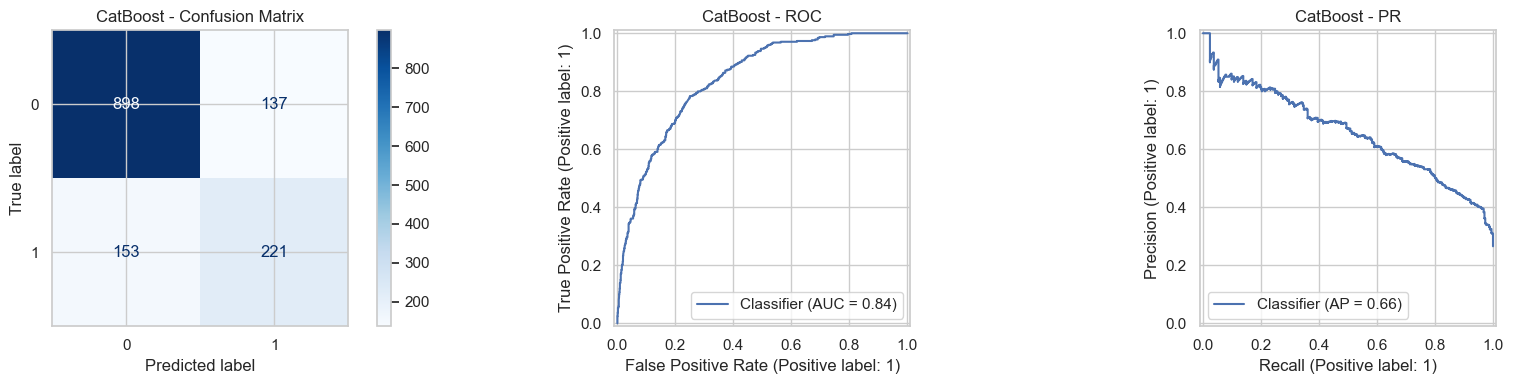

In [15]:
# CatBoost model with tuned threshold for accuracy
cat_features = [c for c in X.columns if X[c].dtype == "object"]

X_train_full, X_test_cb, y_train_full, y_test_cb = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

cat_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3.0,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=False,
)

cat_model.fit(
    X_train_cb,
    y_train_cb,
    cat_features=[X_train_cb.columns.get_loc(c) for c in cat_features],
    eval_set=(X_val_cb, y_val_cb),
    use_best_model=True,
)

val_proba = cat_model.predict_proba(X_val_cb)[:, 1]
thresholds = np.linspace(0.2, 0.8, 61)
val_acc = []
for t in thresholds:
    preds = (val_proba >= t).astype(int)
    val_acc.append(accuracy_score(y_val_cb, preds))
cat_best_threshold = float(thresholds[int(np.argmax(val_acc))])

cat_metrics = evaluate_model(cat_model, X_test_cb, y_test_cb, label="CatBoost", threshold=cat_best_threshold)
cat_metrics["best_threshold"] = cat_best_threshold

In [16]:
# Recompute comparison table including feature-engineered CatBoost if available
model_frames = [
    pd.DataFrame([log_reg_metrics], index=["log_reg"]),
    pd.DataFrame([rf_metrics], index=["random_forest"]),
    pd.DataFrame([hgb_metrics], index=["hgb"]),
]
if "cat_metrics" in globals():
    model_frames.append(pd.DataFrame([cat_metrics], index=["catboost_base"]))
if "cat_fe_metrics" in globals():
    model_frames.append(pd.DataFrame([cat_fe_metrics], index=["catboost_fe"]))

results = pd.concat(model_frames).sort_values("accuracy", ascending=False)
results

,accuracy,precision,recall,f1,roc_auc,pr_auc,threshold,best_threshold
catboost_fe,0.796309,0.629080,0.566845,0.596343,0.841847,0.652456,0.46,0.46
catboost_base,0.794180,0.617318,0.590909,0.603825,0.842515,0.657886,0.45,0.45
hgb,0.785664,0.618421,0.502674,0.554572,0.832429,0.639856,0.50,NaN
log_reg,0.753726,0.525046,0.756684,0.619934,0.840918,0.632091,0.50,NaN
random_forest,0.703336,0.466565,0.820856,0.594961,0.812108,0.595001,0.50,NaN


In [17]:
# Persist the best-performing model (updated to include feature-engineered CatBoost)
import joblib

best_name = results.index[0]
best_model_map = {
    "log_reg": log_reg_clf,
    "random_forest": rf_clf,
    "hgb": hgb_clf,
}
if "cat_metrics" in globals():
    best_model_map["catboost_base"] = cat_model
if "cat_fe_metrics" in globals():
    best_model_map["catboost_fe"] = cat_fe_model

best_model = best_model_map[best_name]

os.makedirs(os.path.join("..", "models"), exist_ok=True)
model_path = os.path.join("..", "models", f"best_model_{best_name}.joblib")
joblib.dump(best_model, model_path)
print(f"Saved {best_name} model to {model_path}")

best_threshold = results.loc[best_name].get("best_threshold", results.loc[best_name].get("threshold", 0.5))
feature_set = "fe" if "catboost_fe" == best_name else "base"
threshold_path = os.path.join("..", "models", f"best_threshold_{best_name}.json")
json.dump({"threshold": float(best_threshold), "feature_set": feature_set}, open(threshold_path, "w"))
print(f"Saved decision threshold {best_threshold:.3f} to {threshold_path} (feature_set={feature_set})")

Saved catboost_fe model to ../models/best_model_catboost_fe.joblib
Saved decision threshold 0.460 to ../models/best_threshold_catboost_fe.json (feature_set=fe)


In [18]:
# Inference example using saved feature set metadata
threshold_info = json.load(open(threshold_path))
threshold_loaded = threshold_info.get("threshold", 0.5)
feature_set = threshold_info.get("feature_set", "base")

example_base = X.iloc[[0]].copy()

if feature_set == "fe":
    example = add_features(example_base)
    example_for_model = example
else:
    example_for_model = example_base

loaded_model = joblib.load(model_path)
pred_proba = loaded_model.predict_proba(example_for_model)[0, 1]
pred_label = int(pred_proba >= threshold_loaded)

print("Example customer features (base):\n", example_base)
print(f"\nPredicted churn probability: {pred_proba:.3f}")
print(f"Predicted label (threshold {threshold_loaded:.2f}, feature_set={feature_set}): {'Churn' if pred_label == 1 else 'No Churn'}")

Example customer features (base):
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   

  PaperlessBilling     PaymentMethod  MonthlyCharges  TotalCharges  
0              Yes  Electronic check           29.85         29.85  

Predicted churn probability: 0.516
Predicted label (threshold 0.46, feature_set=fe): Churn


/var/folders/zk/n02p85rd0dl_bf9pbykq9j700000gn/T/ipykernel_43698/82683828.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2["services_count"] = df2[service_cols].applymap(lambda x: 1 if x == "Yes" else 0).sum(axis=1)
/var/folders/zk/n02p85rd0dl_bf9pbykq9j700000gn/T/ipykernel_43698/82683828.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2["streaming_count"] = df2[["StreamingTV", "StreamingMovies"]].applymap(lambda x: 1 if x == "Yes" else 0).sum(axis=1)


In [19]:
# Compare models
model_frames = [
    pd.DataFrame([log_reg_metrics], index=["log_reg"]),
    pd.DataFrame([rf_metrics], index=["random_forest"]),
    pd.DataFrame([hgb_metrics], index=["hgb"]),
]
if "cat_metrics" in globals():
    model_frames.append(pd.DataFrame([cat_metrics], index=["catboost"]))

results = pd.concat(model_frames).sort_values("accuracy", ascending=False)
results

,accuracy,precision,recall,f1,roc_auc,pr_auc,threshold,best_threshold
catboost,0.794180,0.617318,0.590909,0.603825,0.842515,0.657886,0.45,0.45
hgb,0.785664,0.618421,0.502674,0.554572,0.832429,0.639856,0.50,NaN
log_reg,0.753726,0.525046,0.756684,0.619934,0.840918,0.632091,0.50,NaN
random_forest,0.703336,0.466565,0.820856,0.594961,0.812108,0.595001,0.50,NaN


In [20]:
# Persist the best-performing model
import joblib

best_name = results.index[0]
best_model_map = {
    "log_reg": log_reg_clf,
    "random_forest": rf_clf,
    "hgb": hgb_clf,
}
if "cat_metrics" in globals():
    best_model_map["catboost"] = cat_model

best_model = best_model_map[best_name]

os.makedirs(os.path.join("..", "models"), exist_ok=True)
model_path = os.path.join("..", "models", f"best_model_{best_name}.joblib")
joblib.dump(best_model, model_path)
print(f"Saved {best_name} model to {model_path}")

# Persist best threshold
best_threshold = results.loc[best_name].get("best_threshold", results.loc[best_name].get("threshold", 0.5))
threshold_path = os.path.join("..", "models", f"best_threshold_{best_name}.json")
json.dump({"threshold": float(best_threshold)}, open(threshold_path, "w"))
print(f"Saved decision threshold {best_threshold:.3f} to {threshold_path}")

Saved catboost model to ../models/best_model_catboost.joblib
Saved decision threshold 0.450 to ../models/best_threshold_catboost.json


In [21]:
# Inference example with saved threshold
loaded_model = joblib.load(model_path)
threshold_info = json.load(open(threshold_path))
threshold_loaded = threshold_info.get("threshold", 0.5)

example = X_test.iloc[[0]].copy()
pred_proba = loaded_model.predict_proba(example)[0, 1]
pred_label = int(pred_proba >= threshold_loaded)

print("Example customer features:\n", example)
print(f"\nPredicted churn probability: {pred_proba:.3f}")
print(f"Predicted label (threshold {threshold_loaded:.2f}): {'Churn' if pred_label == 1 else 'No Churn'}")

Example customer features:
      customerID gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
437  4376-KFVRS   Male              0     Yes        Yes      72          Yes   

    MultipleLines InternetService OnlineSecurity OnlineBackup  \
437           Yes     Fiber optic            Yes          Yes   

    DeviceProtection TechSupport StreamingTV StreamingMovies  Contract  \
437              Yes         Yes         Yes             Yes  Two year   

    PaperlessBilling            PaymentMethod  MonthlyCharges  TotalCharges  
437              Yes  Credit card (automatic)          114.05        8468.2  

Predicted churn probability: 0.069
Predicted label (threshold 0.45): No Churn
